### Environmental Effect on Egg Production.

In this notebook we are going to create a machine learning model that will be able to predict egg production to farmers using the  `Environmental Effect on Egg Production` dataset that was obtained on kaggle [`Environmental Effect on Egg Production`](https://www.kaggle.com/datasets/junnn0126/university-students-mental-health).

> **About the dataset:** This comprehensive dataset provides a fascinating look into the intricacies of poultry farming, specifically focusing on egg production. Captured across diverse farm conditions, it gives us key insights into environmental factors and farming practices, allowing us to understand their influence on egg yield. https://www.kaggle.com/datasets/faysal1998/environmental-effect-on-egg-production

We are going to evaluate different Machine learning Algorithims not limmited to the following:

1. `DecisionTreeRegressor`
2. `SVR`
3. `RandomForestRegressor`
4. `LinearRegression`
5. `KNeighborsRegressor`

We are going to choose the best algorithm to perform a regression task on predicting the `egg production` of a student using the following variables:

1. **Features**
- `Amount_of_chicken`: This likely represents the number of chickens in the farm or enclosure.
- `Amount_of_Feeding`: This could represent the quantity of food fed to the chickens, likely in kilograms or pounds.
- `Ammonia`: Ammonia level probably in the chicken coop or enclosure. Ammonia is a gas that is produced by the decomposition of chicken waste and can be harmful to chickens in high concentrations.
- `Temperature`: The temperature inside the chicken coop or enclosure, likely measured in degrees Celsius.
- `Humidity`: The humidity inside the chicken coop or enclosure, likely measured in percentage.
- `Light_Intensity`: The intensity of light in the chicken coop or enclosure.
- `Noise`: The noise level in the chicken coop or enclosure, likely measured in decibels.

2. **Target:**
- `Total_egg_production`: The total number of eggs produced by the chickens.


In the following code cell we are going to install all packages that we are to use in this notebook.

In [3]:
!pip install pigmenta helperfns kaggle -q

### Import of modules

In the following code cell we are going to import all the packages that are going to be used in this notebook.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import random
import os
import json

from joblib import dump
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from helperfns.tables import tabulate_data

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt
import xgboost as xgb
from pigmenta import PALETTES

warnings.filterwarnings("ignore")

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("xgb:", xgb.__version__)

pandas: 2.2.2
numpy: 2.0.2
xgb: 3.0.4


### Seed
Next we are going to set the seed for all random operations for reproducivity of results in this notebook.

In [8]:
SEED = 33

np.random.seed(SEED)
random.seed(SEED)

### Data
In the following code cell we are going to define the path to where the data is located.

We are going to use the kaggle API to download the dataset from kaggle.

> https://www.kaggle.com/datasets/faysal1998/environmental-effect-on-egg-production

In [9]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']
!kaggle datasets download faysal1998/environmental-effect-on-egg-production --unzip

path = "Egg_Production.csv"

Dataset URL: https://www.kaggle.com/datasets/faysal1998/environmental-effect-on-egg-production
License(s): CC0-1.0
  0% 0.00/1.28k [00:00<?, ?B/s]
100% 1.28k/1.28k [00:00<00:00, 5.00MB/s]


Next we are going to read the data into a pandas dataframe.

In [11]:
data = pd.read_csv(path)
data.head(2)

,Amount_of_chicken,Amount_of_Feeding,Ammonia,Temperature,Humidity,Light_Intensity,Noise,Total_egg_production
0,2728,170,14.4,29.3,51.7,364,214,2115
1,2728,175,17.6,29.3,52.3,369,235,1958


In the following code cell we are going to drop all `na` values that might exists in columns of this dataset.

In [51]:
if any(data.isna().any()):
    data.dropna(inplace=True)

### Data Insights
In the following code cell we are going to visualize the distribution of features in the dataset.

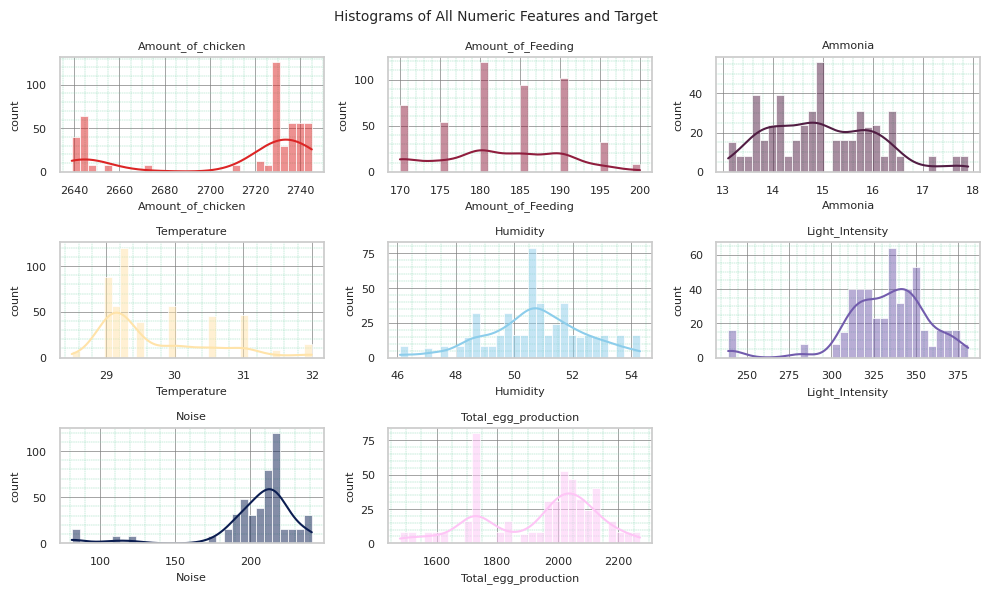

In [54]:
numeric_features = data.columns
plt.figure(figsize=(10, 6))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[col], kde=True, bins=30, color=PALETTES.space[i])
    plt.title(col, fontsize=8)
    plt.xlabel(col, fontsize=8)
    plt.ylabel("count", fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.suptitle("Histograms of All Numeric Features and Target", fontsize=10)
plt.tight_layout()
plt.show()

### Splitting the data into 2 sets

In the following code cell we are going to split the data into 2 sets which are `train` and `test`.

In [55]:
train, test = train_test_split(
    data, test_size=0.15, random_state=SEED
)

Next we are going to check the distribution of data in each set.

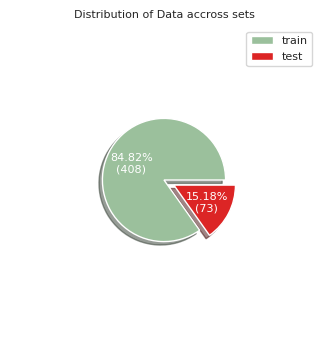

In [56]:
dist_sets = {'train': len(train), 'test': len(test)}
def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)
plt.figure(figsize=(4, 4))
plt.title("Distribution of Data accross sets", fontsize=8)
plt.pie(
    dist_sets.values(), labels=dist_sets.keys(), autopct=lambda x: fmt(x, len(data)),
    textprops={'color': 'white', 'fontsize':8}, radius=.5, explode=[.0, .09],
    colors=PALETTES.space, shadow=True,
)
plt.legend(fontsize=8)
plt.show()

### Extracting features and Labels

In the next code cell we are going to extract features and labels from our dataset. We are going to have `Total_egg_production` as our target label.

For both training and testing dataset. After extracting the labels we are going to transform them.

In [57]:
y_train = train.Total_egg_production.values
y_test = test.Total_egg_production.values

In [58]:
y_train[:2]

array([2190, 2202])

In [59]:
y_test[:2]

array([2115, 1723])

In the next code cell we are going to define the scaler for our labels.

In [60]:
scaler = StandardScaler()

In the next code cell we are then going to transform our labels using the `StandardScaler` created above.

In [66]:
def scale_labels(scaler, train, test):
    train = scaler.fit_transform(train.reshape(-1, 1))
    return train.reshape(-1), scaler.transform(test.reshape(-1, 1)).reshape(-1)

train_labels, test_labels = scale_labels(scaler, y_train, y_test)

In the following code cell we are going to remove `Total_egg_production` so that we extract our features.

In [62]:
train.drop(columns=["Total_egg_production"], inplace=True)
test.drop(columns=["Total_egg_production"], inplace=True)

train.head(2)

,Amount_of_chicken,Amount_of_Feeding,Ammonia,Temperature,Humidity,Light_Intensity,Noise
221,2741,190,13.6,30.0,51.2,341,226
416,2735,185,14.9,29.5,50.7,317,202


We are going to use the `StandardScaler` to transform all the features in the dataframe for test and train sets.

In [63]:
scale_pipeline = Pipeline([
    ('standard_scaler', StandardScaler())
])

ct = ColumnTransformer([
    ("scale pre-processing", scale_pipeline, train.columns)
], remainder='passthrough')
train_features = ct.fit_transform(train)
test_features = ct.transform(test)

In [64]:
test_features[0]

array([ 0.48090411, -1.56915548, -0.55839443, -0.45451716,  0.5740431 ,
        1.19819016,  0.35360573])

### Feature Impotance

In the following code cell we are going to create a function that will use the `XGBRegressor` algorithm to compute feature how important is for each feature in predicting `Total_egg_production` of students.  

In [65]:
def get_feature_impotance(train_features, train_labels, test_features, test_labels):
    xgb_model = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:linear',
        max_depth=3,
        learning_rate=0.01
    )
    xgb_model.fit(
        train_features, train_labels,
        eval_set=[(train_features, train_labels), (test_features, test_labels)],
        verbose=100
   )
    return xgb_model.feature_importances_

Next we are going to get all the features importance array for the `Total_egg_production`.

In [67]:
fi = get_feature_impotance(train_features, train_labels, test_features, test_labels)

[0]	validation_0-rmse:1.10808	validation_1-rmse:0.97056
[100]	validation_0-rmse:0.51048	validation_1-rmse:0.49005
[200]	validation_0-rmse:0.32936	validation_1-rmse:0.35034
[300]	validation_0-rmse:0.26306	validation_1-rmse:0.29284
[400]	validation_0-rmse:0.21485	validation_1-rmse:0.24067
[500]	validation_0-rmse:0.17898	validation_1-rmse:0.19810
[600]	validation_0-rmse:0.15256	validation_1-rmse:0.16721
[700]	validation_0-rmse:0.12942	validation_1-rmse:0.14259
[800]	validation_0-rmse:0.10791	validation_1-rmse:0.12059
[900]	validation_0-rmse:0.08981	validation_1-rmse:0.10015
[999]	validation_0-rmse:0.07455	validation_1-rmse:0.08247


Next we are going to create a dataframe that we are going to use to plot the feature importance, for `egg production`.

In [69]:
Total_egg_production_fi = pd.DataFrame(
    data=fi,
    index=train.columns,
    columns=['importance']
)
Total_egg_production_fi.head()

,importance
Amount_of_chicken,0.742390
Amount_of_Feeding,0.034367
Ammonia,0.025513
Temperature,0.055490
Humidity,0.034586


In the following code cell we are going how important is each feature in predicting `Total_egg_production`.

<Figure size 400x200 with 0 Axes>

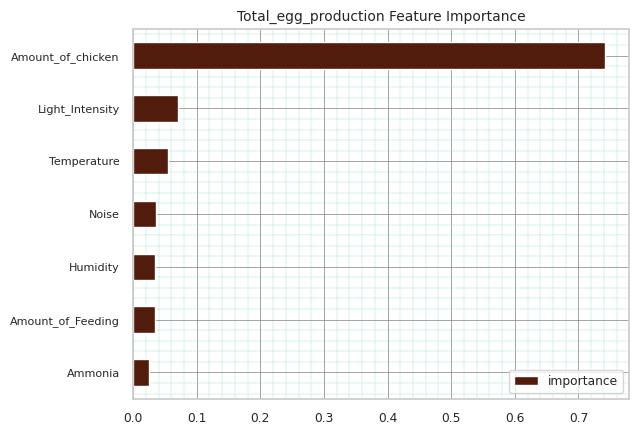

In [70]:

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(4, 2))

Total_egg_production_fi.sort_values('importance').plot(kind='barh', color=PALETTES.fall)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.yticks(fontsize=8)
plt.title('Total_egg_production Feature Importance', fontsize=10)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

> We can see that `Amount of Chicken` is the most important feature in predicting egg production.


### Model Selection

In the following code cell we are going to train `5` Regression Algorithm so that we can see which one will perform better among:

1. `Linear Regression (LR)`
2. `Decision Tree Regressor (DTR)`
3. `Random Forest Regressor (RFR)`
4. `Support Vector Regressor (SVR)`
5. `K-Neighbors Regressor (KNR)`


We are going to evaluate the models/algorithims so that we choose the best model for this task.

In [71]:
pipeline_lr = Pipeline([('lr_regressor', LinearRegression())])
pipeline_dt = Pipeline([ ('dt_regressor', DecisionTreeRegressor())])
pipeline_rf = Pipeline([('rf_regressor', RandomForestRegressor())])
pipeline_svr = Pipeline([('sv_regressor', SVR())])
pipeline_knn = Pipeline([('knn_regressor', KNeighborsRegressor())])

pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svr, pipeline_knn]
pipe_dict = {0: 'LR', 1: 'DTR', 2: 'RFR', 3: "SVR", 4: 'KNR'}

def get_scores(X_train, y_train, X_test, y_test):
    for pipe in pipelines:
        pipe.fit(X_train, y_train)

    scores = []
    for i, model in enumerate(pipelines):
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse =  mean_squared_error(y_test, y_pred)
        rscore = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)
        score = {
            'mae': mae, 'mse': mse, 'rmse': rmse, 'r2-score': rscore, 'regressor': pipe_dict[i]
        }
        scores.append(score)
    return scores

Next we are going to get the scores for `Total_egg_production` and see which algorithm perfoms better.

In [72]:
scores = get_scores(train_features, train_labels, test_features, test_labels)
scores

[{'mae': 0.4090055986691485,
  'mse': 0.30075522372281316,
  'rmse': np.float64(0.5484115459422907),
  'r2-score': 0.6352221747751119,
  'regressor': 'LR'},
 {'mae': 5.094859085608595e-17,
  'mse': 8.674599530335933e-33,
  'rmse': np.float64(9.313753019237698e-17),
  'r2-score': 1.0,
  'regressor': 'DTR'},
 {'mae': 0.0013802322775472468,
  'mse': 1.7431545395009465e-05,
  'rmse': np.float64(0.004175110225492193),
  'r2-score': 0.9999788577530232,
  'regressor': 'RFR'},
 {'mae': 0.13510087407462967,
  'mse': 0.05415176367747697,
  'rmse': np.float64(0.23270531510362408),
  'r2-score': 0.9343207996793846,
  'regressor': 'SVR'},
 {'mae': 0.01994066767353042,
  'mse': 0.007256751647607797,
  'rmse': np.float64(0.08518656964338801),
  'r2-score': 0.9911984834329888,
  'regressor': 'KNR'}]

In [73]:
scores_df  = pd.DataFrame(scores)
scores_df

,mae,mse,rmse,r2-score,regressor
0,4.090056e-01,3.007552e-01,5.484115e-01,0.635222,LR
1,5.094859e-17,8.674600e-33,9.313753e-17,1.000000,DTR
2,1.380232e-03,1.743155e-05,4.175110e-03,0.999979,RFR
3,1.351009e-01,5.415176e-02,2.327053e-01,0.934321,SVR
4,1.994067e-02,7.256752e-03,8.518657e-02,0.991198,KNR


Next we are going to scale our metrics using the `MinMaxScaler` so that they can be plotted on the same axis with a minimum value of 0 and maximum value of 1.

In [74]:
def scale_scores(x, pipeline):
    return pipeline.fit_transform(x.values.reshape(-1, 1)).squeeze()

score_scale_pipeline = MinMaxScaler()

scores_df['mae'] = scale_scores(scores_df['mae'], score_scale_pipeline)
scores_df['mse'] = scale_scores(scores_df['mse'], score_scale_pipeline)
scores_df['rmse'] = scale_scores(scores_df['rmse'], score_scale_pipeline)
scores_df['r2-score'] = scale_scores(scores_df['r2-score'], score_scale_pipeline)

<Figure size 400x300 with 0 Axes>

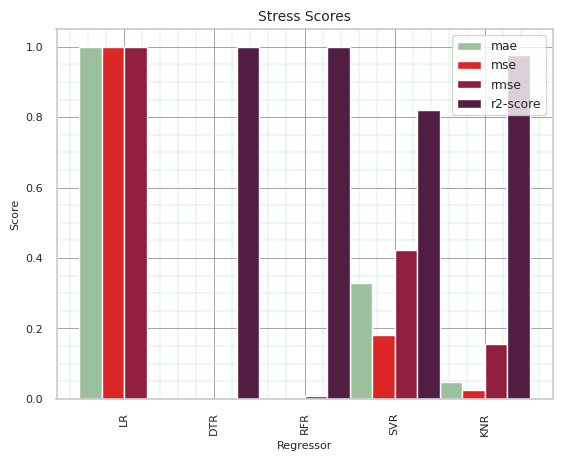

In [75]:
sns.set(font_scale=0.8)
sns.set_style("whitegrid")

plt.figure(figsize=(4, 3))

scores_df.plot(
    x='regressor', kind='bar', stacked=False,
    fontsize=8, color=PALETTES.dark, width=1, legend=True
)
plt.title('Stress Scores', fontsize=10)
plt.xlabel('Regressor', fontsize=8)
plt.ylabel('Score', fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()

It seems like the `DTR` model did well compared to othee regressors. From the above plot it is observed that the `DTR` algorithm performs better than others, (with a larger r_2score of `1`) compared to others, indicating that the `DTR` algorithm found the best fit for the data.

Next we are going to use the  `GridSearchCV` to find the best parameters which are the best for this model.

In [76]:
def get_regressor(X_train, y_train):
    parameters = {'criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
                  'max_features':["sqrt", "log2"] }
    regressor = DecisionTreeRegressor()
    gs = GridSearchCV(regressor, parameters)
    gs.fit(X_train, y_train)
    regressor = DecisionTreeRegressor(**gs.best_params_)
    return gs.best_params_, regressor.fit(X_train, y_train)

Next we are going to get the best model for these features.

In [77]:
regressor_best_params, regressor = get_regressor(train_features, train_labels)

In [78]:
regressor_best_params

{'criterion': 'squared_error', 'max_features': 'log2'}

### Regressor Evaluation
In the following code cell we are going to evaluate our regressors based on the test dataset.

In [79]:
def get_evaluation_scores(regressor, X_test, y_test):
    y_pred = regressor.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse =  mean_squared_error(y_test, y_pred)
    rscore = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    score = {
        'mae': mae, 'mse': mse, 'rmse': rmse, 'r2-score': rscore
    }
    return score

In the following code cell we are going to make some display the metric scores based on the test dataset, for the `Decision Tree Regressor` algorithm.

In [81]:
scores = get_evaluation_scores(regressor, test_features, test_labels)
combined_data = []
for metric in scores:
    combined_data.append([
        metric.upper(),
        f"{scores[metric]:,.3f}"
    ])

headers = ['Metric', 'Score']
tabulate_data(headers, combined_data, title="Decision Tree Regressor Evaluation Metrics")

Decision Tree Regressor Evaluation Metrics
+----------+-------+
| Metric   | Score |
+----------+-------+
| MAE      | 0.000 |
| MSE      | 0.000 |
| RMSE     | 0.000 |
| R2-SCORE | 1.000 |
+----------+-------+


### Making predictions.

Next we are going to predict `Egg Production` using the data that we have in the test dataset.

In [82]:
def predict_eggs(data, labels):
    test_dataframe = data.reset_index(drop=True)
    features = ct.transform(test_dataframe)
    eggs = regressor.predict(features).reshape(-1, 1)
    result = pd.DataFrame({
        'eggs': labels,
        'Predicted eggs': scaler.inverse_transform(eggs).reshape(-1)
    })
    return result

predictions = predict_eggs(test, y_test)
predictions.head()

,eggs,Predicted eggs
0,2115,2115.0
1,1723,1723.0
2,1989,1989.0
3,1972,1972.0
4,1988,1988.0


### Saving the best model

In the following code cell we are going to save the best model. Saving both model, ct and scaler in one file.

In [83]:
dump({
    "model": regressor,
    "column_transformer": ct,
    "scaler": scaler
}, "egg_production_bundle.joblib")
print("Done!")

Done!


Next need to check the version of `sklearn` used to train the regressor.

In [84]:
import sklearn
print(sklearn.__version__)

1.6.1


In [85]:
test.head(2)

,Amount_of_chicken,Amount_of_Feeding,Ammonia,Temperature,Humidity,Light_Intensity,Noise
122,2728,170,14.4,29.3,51.7,364,214
29,2640,185,14.2,29.0,50.5,343,216


In [86]:
test.columns

Index(['Amount_of_chicken', 'Amount_of_Feeding', 'Ammonia', 'Temperature',
       'Humidity', 'Light_Intensity', 'Noise'],
      dtype='object')

In [87]:
test.dtypes

,0
Amount_of_chicken,int64
Amount_of_Feeding,int64
Ammonia,float64
Temperature,float64
Humidity,float64
Light_Intensity,int64
Noise,int64
